In [2]:
import numpy as np
import matplotlib.pyplot as plt
import CosmoBolognaLib as cbl
from CosmoBolognaLib import DoubleVector as dv
from CosmoBolognaLib import DoubleVectorVector as dvv

import os 
from matplotlib import rc
from scipy.integrate import quad, romb
from scipy.interpolate import interp1d

rc('text', usetex=True)
rc('font', family='serif')
rc('font', size=14)

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

from multiprocessing import Pool, cpu_count
os.environ["OMP_NUM_THREADS"] = "1"
import emcee
from chainconsumer import ChainConsumer

eb_default_kwargs = {"ls" : "",
                     "barsabove" : False,
                     "ecolor" : "k",
                     "mec" : "k",
                     "elinewidth" : 1.2,
                     "mew" : 1.2,
                     "capsize" : 3}

In [3]:
import CosmoBolognaLib as cbl

cbl.SetDirs("/home/alfonso/CosmoBolognaLib/", cbl.fullpath("./"))

In [4]:
from loopfftlog import *

In [5]:
path = "../../gc-wp-nonlinear/linear_spectra_flagship/matter/high_res/"

In [6]:
#Dictionary to fill missing part of the file name
 
snap_to_name = {"00026" : "halosAbove90",
                "00030" : "halosAbove80",
                "00037" : "halosAbove56",
                "00045" : "halosAbove48"}

truth = {"00026" : [2.4833, 1.0264, -0.8572, 2.0867, 7.4191],
         "00030" : [2.0209, -0.1183, -0.5516, 1.1307, 2.0627],
         "00037" : [1.7370, -0.3630, -0.3863, 0.7533, 3.7055],
         "00045" : [1.3679, -0.6209, -0.2283, 0.4114, 2.8042]
        }
snap_to_z = {"00026" : 4,
             "00030" : 3,
             "00037" : 2,
             "00045" : 1}

snap_list = ["00045", "00037", "00030", "00026"]

model_rad = np.linspace(1., 150, 200)

Dz = {"00045" : 0.63178,
      "00037" : 0.55868,
      "00030" : 0.48880,
      "00026" : 0.44589}

cosmology = cbl.Cosmology()

pk_EH = np.genfromtxt(path+"EH_linear_spectra_flagship_high_res_matterpower_z0p0.dat", unpack=True)
pk_Lin = np.genfromtxt(path+"flagship_linear_cb_hr_matterpower_z0p0.dat", unpack=True)

kk = pk_EH[0]
pk_NW = np.array(cosmology.Pk_DM_NoWiggles_gaussian (kk, pk_Lin[1], pk_EH[1], 0.25, "gaussian_1d"))

interp_pk_NW = interp1d(kk, pk_NW, kind="cubic") 
interp_pk_Lin = interp1d(kk, pk_Lin[1], kind="cubic") 

kBAO = np.pi/110.
ks = 0.2
integrand = lambda q : interp_pk_NW(q) * (1 - cbl.j0(q / kBAO) + 2 * cbl.j2(q / kBAO))
    
sigma2 = quad(integrand, 1.e-6, ks, limit = 100, epsabs = 0, epsrel = 10**(-5))[0]/(6*np.pi**2)

In [7]:
diagram_names = r"$b_1 b_2$",\
                r"$b_1 b_{\mathcal{G}_2}$",\
                r"$b_2 b_2$",\
                r"$b_2 b_{\mathcal{G}_2}$",\
                r"$b_{\mathcal{G}_2} b_{\mathcal{G}_2}$",\
                r"$b_1 b_{\Gamma_3}$"


In [8]:
pk_matter = PkMatter(Nmax=512)
pk_matter.set_tables()

pk_bias = PkBias(Nmax=512, bias=-1.6)
pk_bias.set_tables()

rad = np.linspace(1, 200, 100)

xi_matter = XiMatter(Nmax=512, bias=-0.2)
xi_matter.set_tables()

xi_bias = XiBias(Nmax=512, bias=-1.6)
xi_bias.set_tables()

In [10]:
xi = xi_matter(rad, interp_pk_Lin)

In [11]:
pkSPT = pk_matter(interp_pk_Lin)
pkBias = pk_bias(interp_pk_Lin)
xiBias_from_Pk = [xi_matter(rad, interp1d(pkBias[0], pkBias[i+1], kind="cubic"))\
                  for i in range(6)]
xiBias = np.array(xi_bias(rad, interp_pk_Lin))
print(xiBias.shape)

(7, 100)


In [12]:
figure, axes = plt.subplots(2, 3, figsize=(15, 6))

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(rad, xiBias[i]*rad**2, "-k", label="1 FFTlog", lw=3)
    ax.plot(rad, xiBias_from_Pk[i]*rad**2, "--r", label="2 FFTlogs", lw=3)
    ax.legend(loc="best")
    if (i==2):
        ax.set_ylim(-10, 100)
    ax.set_xlabel(r"$r \, [\mathrm{Mpc} \, h^{-1}]$")
    ax.set_ylabel(r"$r^2 \cdot \xi(r) \, [\mathrm{Mpc}^2 \, h^{-2}]$")
    ax.set_title(diagram_names[i])
    ax.grid(True, color="0.5", ls="--")
figure.tight_layout()

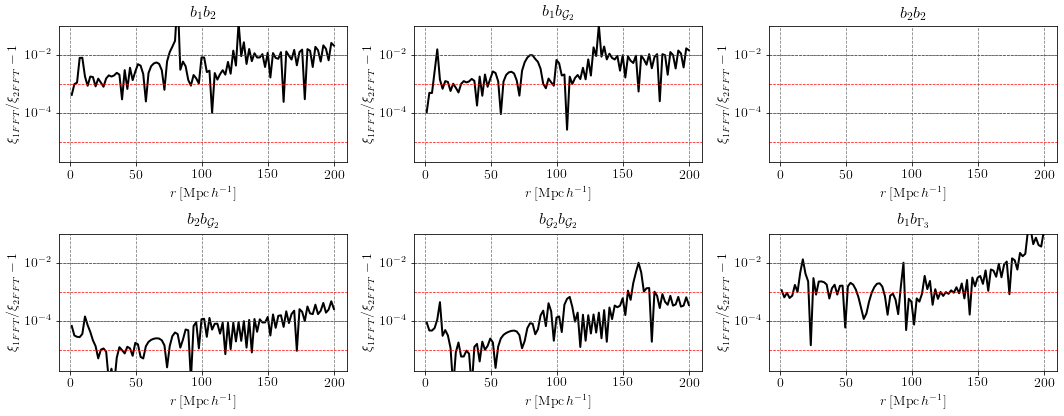

In [13]:
figure, axes = plt.subplots(2, 3, figsize=(15, 6))

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.set_yscale("log")
    ax.plot(rad, np.abs(xiBias[i]/xiBias_from_Pk[i]-1), "-k", lw=2)
    ax.axhline(0.01, color="r", ls="--", lw=0.7)
    ax.axhline(0.001, color="r", ls="--", lw=0.7)
    ax.axhline(0.0001, color="r", ls="--", lw=0.7)
    ax.axhline(0.00001, color="r", ls="--", lw=0.7)

    ax.set_ylim(2.e-6, 0.1)
    ax.set_xlabel(r"$r \, [\mathrm{Mpc} \, h^{-1}]$")
    ax.set_ylabel(r"$ \xi_{1 FFT}/\xi_{2 FFT} -1 $")
    ax.set_title(diagram_names[i])
    ax.grid(True, color="0.5", ls="--")

figure.tight_layout()

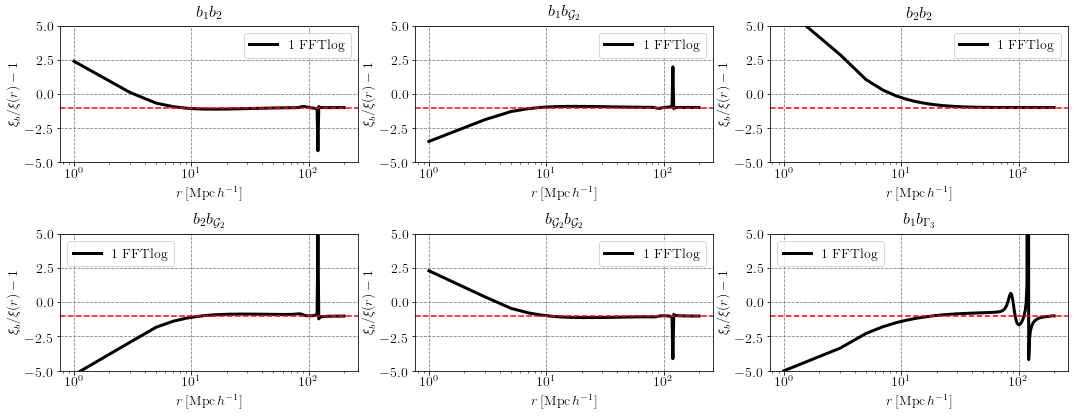

In [51]:
figure, axes = plt.subplots(2, 3, figsize=(15, 6))

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(rad, xiBias[i]/xi - 1, "-k", label="1 FFTlog", lw=3)
    #ax.plot(rad, xiBias_from_Pk[i]/xi - 1, "--r", label="2 FFTlogs", lw=3)
    ax.legend(loc="best")
    ax.set_xscale("log")
    ax.set_ylim(-5, 5)
    ax.set_xlabel(r"$r \, [\mathrm{Mpc} \, h^{-1}]$")
    ax.set_ylabel(r"$\xi_b / \xi (r) - 1$")
    ax.set_title(diagram_names[i])
    ax.grid(True, color="0.5", ls="--")
    ax.axhline(-1, color="r", ls="--")
figure.tight_layout()

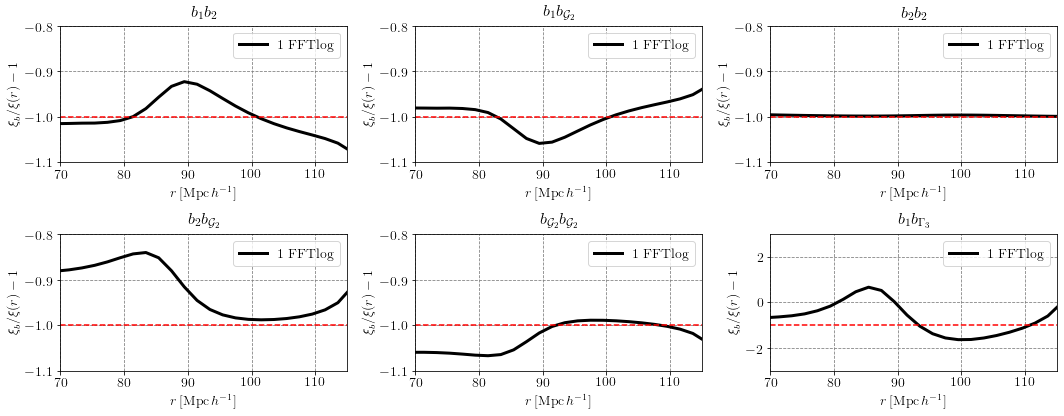

In [50]:
figure, axes = plt.subplots(2, 3, figsize=(15, 6))

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(rad, xiBias[i]/xi - 1, "-k", label="1 FFTlog", lw=3)
    #ax.plot(rad, xiBias_from_Pk[i]/xi - 1, "--r", label="2 FFTlogs", lw=3)
    ax.legend(loc="best")
    ax.set_ylim(-1.1, -0.8)
    if (i==5):
        ax.set_ylim(-3, 3)
    ax.set_xlim(70, 115)
    ax.set_xlabel(r"$r \, [\mathrm{Mpc} \, h^{-1}]$")
    ax.set_ylabel(r"$\xi_b / \xi (r) - 1$")
    ax.set_title(diagram_names[i])
    ax.grid(True, color="0.5", ls="--")
    ax.axhline(-1, color="r", ls="--")
figure.tight_layout()